<a href="https://colab.research.google.com/github/mkierczak/autoencoders_workshop/blob/main/PCA2VAE_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

If you want to try another dataset, you can go for data from Lazaridis et. al. [*Genomic insights into the origin of farming in the ancient Near East*](https://www.nature.com/articles/nature19310) 2016. Nature **536**:419-424. I have pre-prepared chr1 markers at call rate of 0.99 and higher.

In [10]:
# HapMap3 randomly selected 5000 autosomal markers data
!wget -O data.hd5 https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.hd5?rlkey=nz8f9df7tt9n0hrpqg7y19omc&dl=1

# Data for chr1 from Lazaridis et al.
#!wget -O data.hd5 https://www.dropbox.com/scl/fi/kck4puyi1qmuzr65bgdbn/HumanOriginsPublic2068_geno_chr1.hd5?rlkey=xp4nfljz0c2za9ihriletxx3x&dl=1


--2023-09-04 08:42:47--  https://www.dropbox.com/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.hd5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.hd5?rlkey=nz8f9df7tt9n0hrpqg7y19omc [following]
--2023-09-04 08:42:47--  https://www.dropbox.com/e/scl/fi/2daedhwkdjweotnthxee3/HapMap3_5000.hd5?rlkey=nz8f9df7tt9n0hrpqg7y19omc
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7bddba972a6314a6cb35bd7a3e.dl.dropboxusercontent.com/cd/0/inline/CDF398xpMJ3WZWGiaRRFo97wW9xCF6iGz9AyUNb1FPWCT7uB_gY6CPNO9Au2U8WIlJgSMKs42GTa_n5TiT6W6Q-Dw_dBg5iXCw4iyeWbOlWAjs8Dg5QWVAhuvBcvodquoQM/file# [following]
--2023-09-04 08:42:48--  https://uc7bddba972a6314a6cb35bd7a3e.d

In [57]:
orig_geno = pd.read_hdf('./data.hd5', key = 'geno')
orig_pheno = pd.read_hdf('./data.hd5', key = 'pheno')
orig_snp = pd.read_hdf('./data.hd5', key = 'gkin')


In [58]:
print(orig_geno.info())
print(orig_geno.iloc[0:4, 0:4])
print(orig_pheno.iloc[0:4, ])
print(orig_snp.iloc[0:4, ])

<class 'pandas.core.frame.DataFrame'>
Index: 1184 entries, NA19919 to NA19099
Columns: 5000 entries, rs416967 to rs2806497
dtypes: int64(5000)
memory usage: 45.2+ MB
None
         rs416967  rs17013842  rs13052452  rs11049986
NA19919         2           1           0           1
NA19916         1           0           0           1
NA19835         0           0           1           1
NA20282         1           1           0           1
              id  sex   FID      dad      mom  pheno  \
NA19919  NA19919    1  2427  NA19908  NA19909      0   
NA19916  NA19916    1  2431        0        0      0   
NA19835  NA19835    0  2424        0        0      0   
NA20282  NA20282    0  2469        0        0      0   

                         population  
NA19919  African ancestry in SW USA  
NA19916  African ancestry in SW USA  
NA19835  African ancestry in SW USA  
NA20282  African ancestry in SW USA  
          NA19919   NA19916   NA19835   NA20282   NA19703   NA19902   NA19901  \
NA19919

In [59]:
print("Missing genotypes per marker: \n", orig_geno.isna().sum())

Missing genotypes per marker: 
 rs416967      0
rs17013842    0
rs13052452    0
rs11049986    0
rs10994341    0
             ..
rs6557516     0
rs7313246     0
rs317892      0
rs11937009    0
rs2806497     0
Length: 5000, dtype: int64


In [61]:
geno = orig_geno.replace([0, 1.0, 2.0], [0, 0.5, 1.0])
#geno.fillna(0, inplace = True)
#print(geno.isna().sum())
geno


,rs416967,rs17013842,rs13052452,rs11049986,rs10994341,rs1504289,rs882529,rs3885937,rs537330,rs9372090,...,rs1558766,rs7818288,rs1051685,rs11223492,rs789492,rs6557516,rs7313246,rs317892,rs11937009,rs2806497
NA19919,1.0,0.5,0.0,0.5,0.5,0.0,0.0,0.5,0.5,0.5,...,0.0,0.5,0.0,0.0,0.5,0.0,0.5,0.5,0.5,0.0
NA19916,0.5,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.5,0.5,0.0
NA19835,0.0,0.0,0.5,0.5,0.0,0.5,0.0,1.0,1.0,0.5,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
NA20282,0.5,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0
NA19703,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,1.0,...,0.0,0.5,0.5,0.0,0.5,0.5,0.5,0.5,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA19119,0.5,0.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
NA18860,0.5,0.0,0.0,0.5,0.5,0.0,0.0,0.5,1.0,0.5,...,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5
NA19207,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.5,0.0
NA19103,0.5,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0


In [62]:
train = geno.sample(frac = 0.8, random_state = 42)
test = geno.drop(train.index)
pheno = orig_pheno.set_index(keys = 'id')
train_pheno = pheno[pheno.index.isin(train.index)]
test_pheno = pheno.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Original data:", orig_geno.shape)
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Original data: (1184, 5000)
	 - training set: (947, 5000)
	 - test set: (237, 5000)


In [63]:
pheno

,sex,FID,dad,mom,pheno,population
id,,,,,,
NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,1,2431,0,0,0,African ancestry in SW USA
NA19835,0,2424,0,0,0,African ancestry in SW USA
NA20282,0,2469,0,0,0,African ancestry in SW USA
NA19703,1,2368,0,0,0,African ancestry in SW USA
...,...,...,...,...,...,...
NA19119,1,Y060,0,0,0,Yoruba in Ibadan Nigeria
NA18860,1,Y012,NA18859,NA18858,0,Yoruba in Ibadan Nigeria
NA19207,1,Y051,0,0,0,Yoruba in Ibadan Nigeria


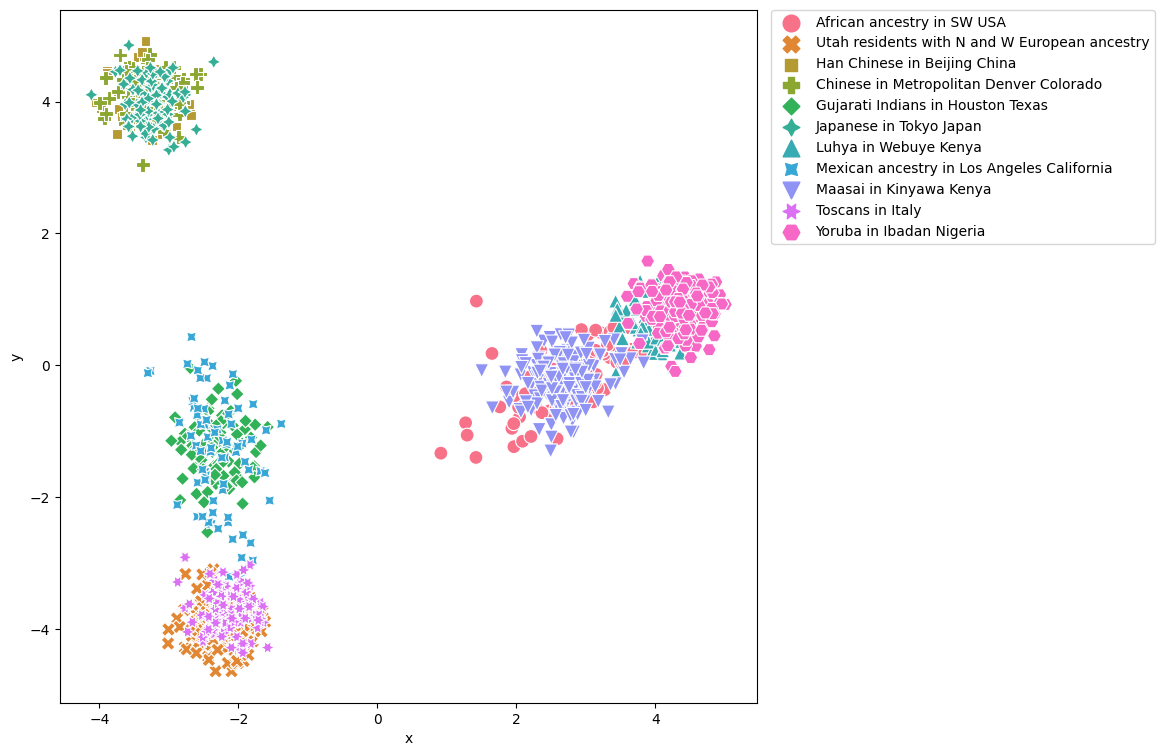

In [64]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(geno)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
pop = pheno.iloc[:,5]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (9,9))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

In [ ]:
#geno_imputed = orig_gt.fillna(orig_gt.mode().iloc[0])
#embedding = PCA(n_components=2)
#pca_embedding = embedding.fit_transform(geno_imputed) * 2
#x = pca_embedding[:,0]
#y = pca_embedding[:,1]
#pop = pheno.iloc[:,1]
#data = {'x':x, 'y':y, 'pop':pop}
#plt.figure(figsize = (9,9))
#sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100, legend=False)
#plt.show()

In [65]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

<class 'numpy.ndarray'>


In [79]:
# Encoder
input = keras.Input(shape = (original_dim,))
output = input

def Encoder_core(input):
  h = layers.Dense(units = 1500, activation = 'relu')(input)
  h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 250, activation = 'relu')(h)
  #h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 25, activation = 'relu')(h)
  #h = layers.BatchNormalization()(h)
  return(h)

def Bottleneck_vanilla(h, latent_dim):
  h = layers.Dense(units = latent_dim, name='layer_bottleneck')(h)
  return(h)

def Decoder(bottleneck, original_dim):
  h = layers.Dense(units = 25, activation = 'relu')(bottleneck)
  #h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 250, activation = 'relu')(h)
  #h = layers.BatchNormalization()(h)
  h = layers.Dense(units = 1500, activation = 'relu')(h)
  #h = layers.BatchNormalization()(h)
  h = layers.Dense(original_dim, activation='sigmoid')(h)
  return(h)

def Autoencoder(input, latent_dim, original_dim):
  encoder = Bottleneck_vanilla(Encoder_core(input), latent_dim)
  autoencoder = Decoder(encoder, original_dim)
  return(autoencoder)

ae_model = keras.Model(inputs = input, outputs = Autoencoder(input, latent_dim, original_dim))

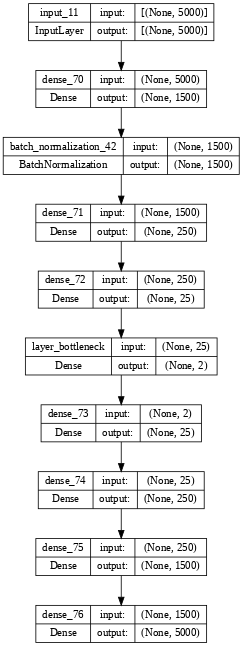

In [80]:
plot_model(ae_model, show_shapes=True, show_layer_names = True, dpi=58, to_file="model.png")

In [81]:
hp_loss_fn = 'mse'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

ae_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics
)
ae_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5000)]            0         
                                                                 
 dense_70 (Dense)            (None, 1500)              7501500   
                                                                 
 batch_normalization_42 (Bat  (None, 1500)             6000      
 chNormalization)                                                
                                                                 
 dense_71 (Dense)            (None, 250)               375250    
                                                                 
 dense_72 (Dense)            (None, 25)                6275      
                                                                 
 layer_bottleneck (Dense)    (None, 2)                 52        
                                                          

In [ ]:
hp_epochs = 30
hp_batch_size = 256
hp_val_split = 0.2

autoencoder = ae_model.fit(x = train_tensor,
                      y = train_tensor,
                      epochs = hp_epochs,
                      batch_size = hp_batch_size,
                      shuffle = True,
                      validation_split = hp_val_split,
                      )

Epoch 1/30
3/3 [==============================] - 4s 730ms/step - loss: 0.1829 - mse: 0.1829 - mae: 0.3695 - mape: 338956096.0000 - val_loss: 0.1805 - val_mse: 0.1805 - val_mae: 0.3665 - val_mape: 336267584.0000
Epoch 2/30
3/3 [==============================] - 2s 806ms/step - loss: 0.1319 - mse: 0.1319 - mae: 0.3186 - mape: 262741872.0000 - val_loss: 0.1011 - val_mse: 0.1011 - val_mae: 0.2889 - val_mape: 220006528.0000
Epoch 3/30
3/3 [==============================] - 3s 824ms/step - loss: 0.0808 - mse: 0.0808 - mae: 0.1834 - mape: 54036068.0000 - val_loss: 0.0723 - val_mse: 0.0723 - val_mae: 0.1888 - val_mape: 91522944.0000
Epoch 4/30
3/3 [==============================] - 2s 574ms/step - loss: 0.0791 - mse: 0.0791 - mae: 0.1653 - mape: 53242220.0000 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.1806 - val_mape: 87904888.0000
Epoch 5/30
3/3 [==============================] - 2s 580ms/step - loss: 0.0752 - mse: 0.0752 - mae: 0.1739 - mape: 71231848.0000 - val_loss: 0.0720 - val_ms

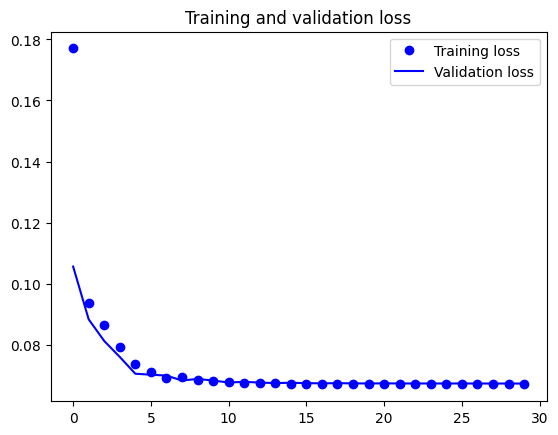

In [76]:
loss = autoencoder.history['mse']
val_loss = autoencoder.history['val_mse']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [77]:
geno_tensor = geno.to_numpy()
geno_dim = geno_tensor.shape[1]
input = keras.Input(shape = (geno_dim,))

ae_model.save_weights('autoencoder_weights.h5',
                               overwrite = True)

trained_model = keras.Model(inputs = input, outputs = Autoencoder(input, latent_dim, geno_dim))
trained_model.load_weights('autoencoder_weights.h5',
                           skip_mismatch = True,
                           by_name = True)
trained_model.compile(
  loss = hp_loss_fn,
  optimizer = hp_optimizer,
  metrics = hp_metrics,
)

37/37 [==============================] - 1s 34ms/step
[[0.5006255  0.5012923  0.50228727 ... 0.5060664  0.50556433 0.5002067 ]
 [0.49994424 0.501668   0.5040774  ... 0.5053053  0.5050546  0.49857736]
 [0.50039643 0.5008271  0.5014953  ... 0.50388324 0.5035789  0.5001034 ]
 ...
 [0.5003112  0.5008469  0.50191766 ... 0.50403476 0.5037978  0.4997815 ]
 [0.50042367 0.5010736  0.5022612  ... 0.5050305  0.50472736 0.4998126 ]
 [0.5006452  0.50106305 0.5017094  ... 0.5052691  0.50449085 0.5006945 ]]


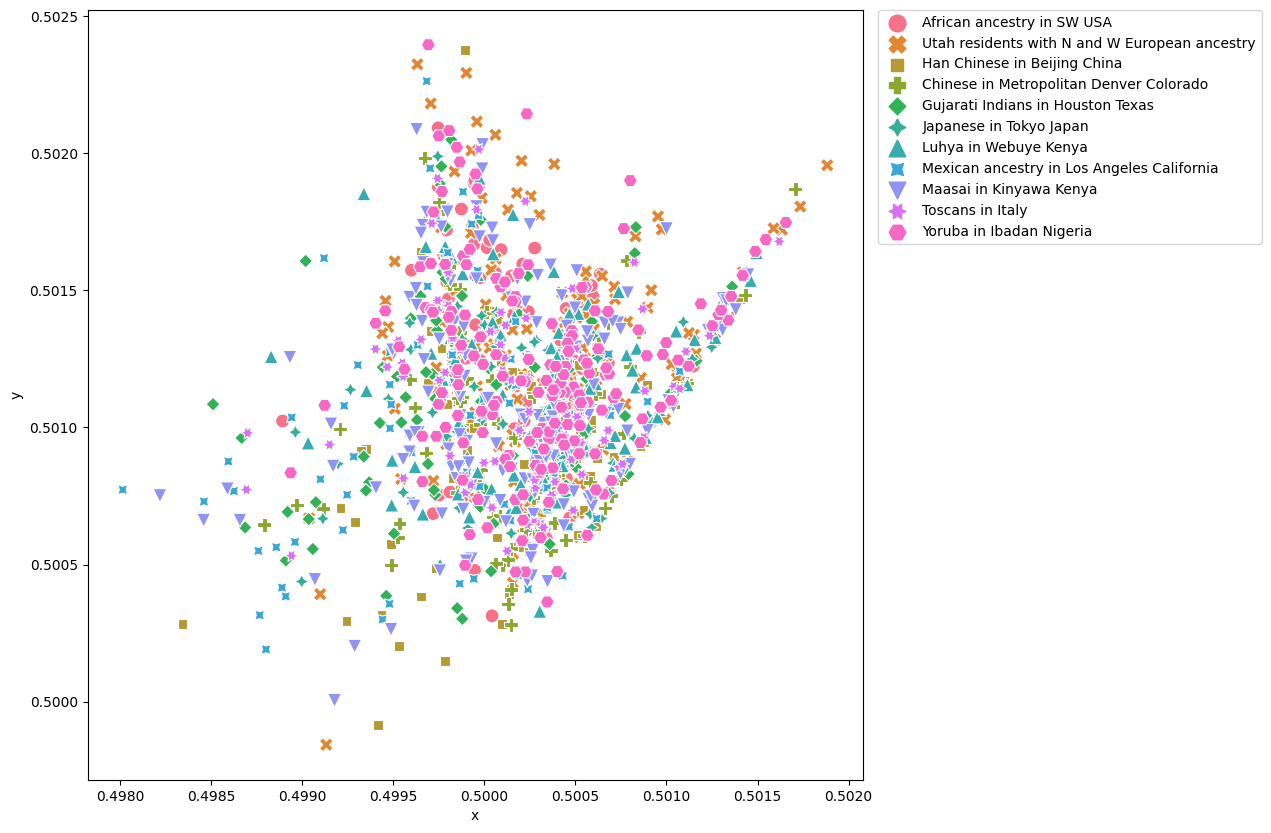

In [78]:
embeded_points = trained_model.predict(geno_tensor)
print(embeded_points)

x = embeded_points[:,0]
y = embeded_points[:,1]
pop = pop
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (10,10))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()